# Gaussian Process and Machine Learning

In [1]:
using ColorSchemes
using Optim
using Plots
using Printf
using Statistics
using LaTeXStrings

In [2]:
include("gp.jl")

gpr (generic function with 1 method)

## Sampling from 1D Gaussian Process

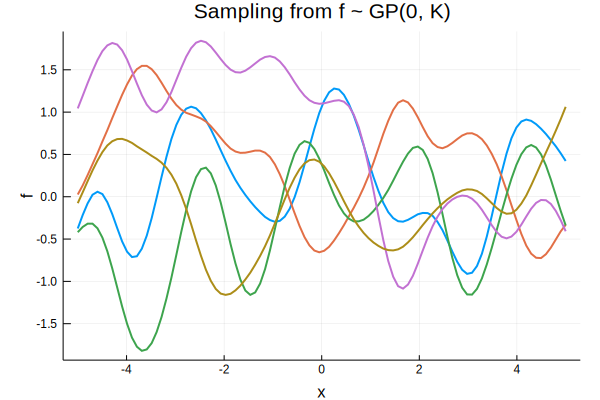

In [3]:
xs = collect(range(-5, stop = 5, length = 100))

gp = GaussianProcess(GaussianKernel(1, 1))
Plots.plot(xs, rand(dist(gp, xs), 5), 
    label = "", xlabel = "x", ylabel = "f",
    linewidth = 2,
    title = "Sampling from f ~ GP(0, K)")

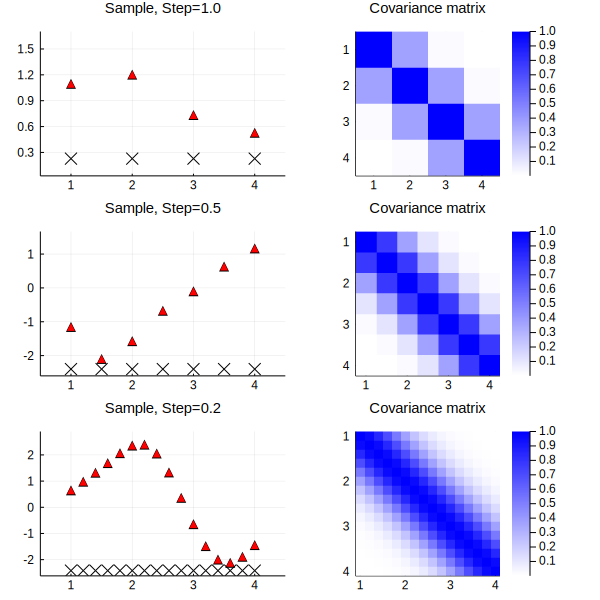

In [4]:
xx = [1:4, 1:0.5:4, 1:0.2:4]
yy = [1, 0.5, 0.2]

plts = []
for (x, y) in zip(xx, yy)
    x1 = collect(x)
    n = Base.length(x)
    sample = rand(dist(gp, x1))
    sample_min = minimum(sample)
    sample_plot = scatter(x, sample, label = "",
            markershape = :utriangle, markercolor = :red,
            title = @sprintf("Sample, Step=%.1f", y), titlefontsize = 10)
    scatter!(x, fill(sample_min - 0.3, n),
        xlims = (0.5, 4.5),
        ylims = (sample_min - 0.5, maximum(sample) + 0.5),
        markershape = :x, markerstrokewidth = 2,
        label = "")
    push!(plts, sample_plot)
    push!(plts, heatmap(x1, x1, cov(gp, x1), 
            title = "Covariance matrix", titlefontsize = 10,
            aspect_ratio = :equal, yflip = true, color = cgrad([:white, :blue])))
end

Plots.plot(plts..., layout = (3, 2), size = [600, 600])

## Sampling from 2D Gaussian Process

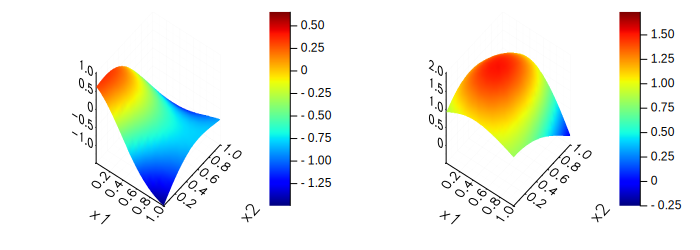

In [5]:
x1, x2 = 0:0.05:1, 0:0.05:1
n1, n2 = Base.length(x1), Base.length(x2)
n = n1 * n2
pt = permutedims(hcat([[i, j] for i in x1, j in x2]...));
sample = rand(dist(gp, pt), 2)

plts = []
for i in 1:2
    z = reshape(sample[:, i], n1, n2)
    push!(plts,
        surface(x1, x2, z, alpha = 0.8, camera = (40, 60),
        seriescolor = cgrad(ColorSchemes.jet1.colors), 
        linewidth = 2,
        framestyle = :grid,
        xlabel = "x1", ylabel = "x2", zlabel = "f"))
end
Plots.plot(plts..., layout = (1, 2), size = [700, 250])

## Kernel Types (Linear, Gaussian, Exponential, Periodic)

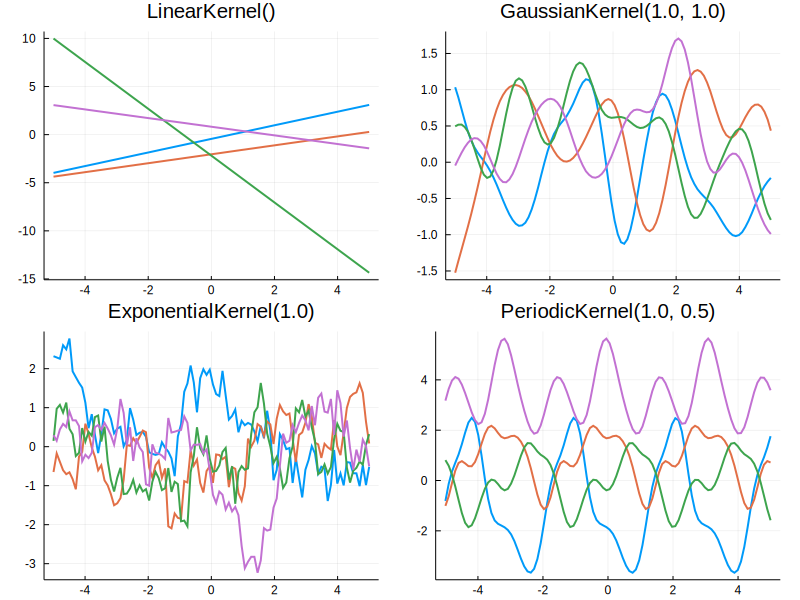

In [6]:
xs = collect(range(-5, stop = 5, length = 100))
kernels = [LinearKernel(), GaussianKernel(1, 1),
           ExponentialKernel(1), PeriodicKernel(1.0, 0.5)]
plts = []

for k in kernels
    gp = GaussianProcess(k)
    p = Plots.plot(xs, rand(dist(gp, xs), 4), label = "", linewidth = 2, title = @sprintf("%s", k))
    push!(plts, p)
end
    
Plots.plot(plts..., layout = (2, 2), size = [800, 600])

## Linear combination

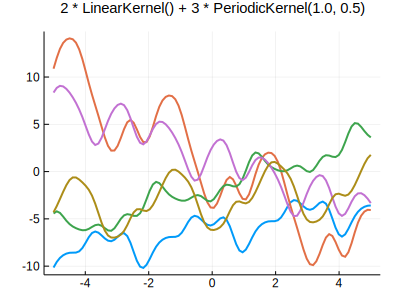

In [7]:
xs = collect(range(-5, stop = 5, length = 100))
l_ker = 2.0 * LinearKernel() + 3.0 * PeriodicKernel(1.0, 0.5)

gp = GaussianProcess(l_ker)
Plots.plot(xs, rand(dist(gp, xs), 5), 
    label = "", size = [400, 300],
    linewidth = 2,
    title = "2 * LinearKernel() + 3 * PeriodicKernel(1.0, 0.5)", titlefontsize = 10)

## Matérn kernel

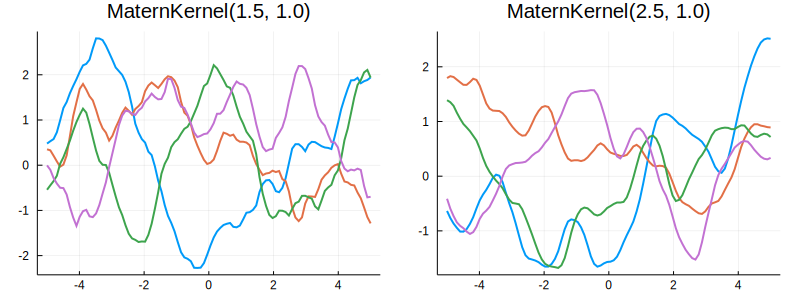

In [8]:
xs = collect(range(-5, stop = 5, length = 100))
kernels = [MaternKernel(3/2, 1.), MaternKernel(5/2, 1.)]
plts = []

for k in kernels
    gp = GaussianProcess(k)
    p = Plots.plot(xs, rand(dist(gp, xs), 4), label = "", linewidth = 2, title = @sprintf("%s", k))
    push!(plts, p)
end
    
Plots.plot(plts..., layout = (1, 2), size = [800, 300])

## Gaussian Process Regression

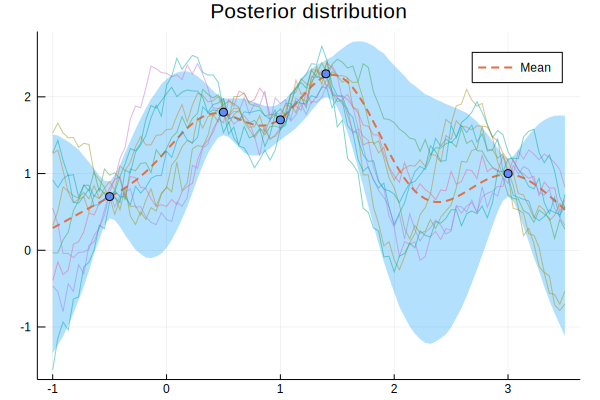

In [9]:
xs = [-0.5, 0.5, 1, 1.4, 3]
ys = [0.7, 1.8, 1.7, 2.3, 1]
gp = GaussianProcess(GaussianKernel(1.0, 0.4), 0.01)
xtrain = collect(range(-1, stop=3.5, length=100))
pred = gpr(gp, xtrain, xs, ys)
qt = mapslices(x -> quantile(x, [0.025, 0.925]), rand(pred, 10000), dims = 2)

Plots.plot(xtrain, qt[:, 1], fillrange = qt[:, 2], fillalpha = 0.3,
    label = "", linewidth = 0)
Plots.plot!(xtrain, mean(pred), label = "Mean", linewidth = 2, linestyle = :dash)
Plots.plot!(xtrain, rand(pred, 10), label = "", linewidth = 1, linealpha = 0.5)

scatter!(xs, ys, label = "", title = "Posterior distribution")

## Hyperparameter optimization with Optim.jl

In [10]:
struct HyperParamHelper1
    gp::GaussianProcess
    xs::Vector{Float64}
    ys::Vector{Float64}
    n_xs::Int64
    distance_matrix::Matrix{Float64}
end

function HyperParamHelper1(gp::GaussianProcess, xs::Vector{Float64}, ys::Vector{Float64})
    n_xs = Base.length(xs)
    distance_matrix = zeros(n_xs, n_xs)
    for i in 1:n_xs
        for j in 1:n_xs
            distance_matrix[i, j] = (xs[i] - xs[j]).^2
        end
    end
    HyperParamHelper1(gp, xs, ys, n_xs, distance_matrix)
end

function logp!(hp::HyperParamHelper1, x)
    y = exp.(x)
    update!(hp.gp, y...)
    n = Base.length(hp.xs)
    n * log(2* pi) + 2 * logpdf(dist(hp.gp, hp.xs), hp.ys)
end

function g!(hp::HyperParamHelper1, G, x)
    y = exp.(x)
    k = cov(hp.gp, hp.xs)
    k_inv = inv(k)
    k_inv_y = k_inv * ys
    d_tau = k - y[3] .* Matrix{Float64}(I, n, n)
    d_sigma = d_tau ./ y[2] .* distance_matrix
    d_eta = y[3] .* Matrix{Float64}(I, n, n)
    G[1] = -tr(k_inv * d_tau) + k_inv_y' * d_tau * k_inv_y
    G[2] = -tr(k_inv * d_sigma) + k_inv_y' * d_sigma * k_inv_y
    G[3] = -tr(k_inv * d_eta) + k_inv_y' * d_eta * k_inv_y
    G
end

g! (generic function with 1 method)

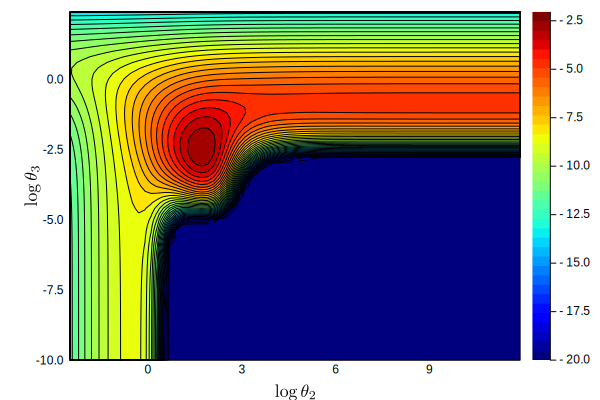

In [11]:
xs = [-0.5, 0.5, 1, 1.4, 3]
ys = [0.7, 1.8, 1.7, 2.3, 1]

hp1 = HyperParamHelper1(GaussianProcess(GaussianKernel(1, 1), 1), xs, ys)

theta2, theta3 = -2.5:0.2:12, -10:0.2:2.5
z = Surface((x, y) -> max(-20, logp!(hp1, [0, x, y])), theta2, theta3)
contourf(theta2, theta3, z, seriescolor = cgrad(ColorSchemes.jet1.colors), 
    levels = collect(-20:0.5:-2),
    xlabel = L"\log \theta_2", ylabel = L"\log \theta_3",
    guidefont=font(12))

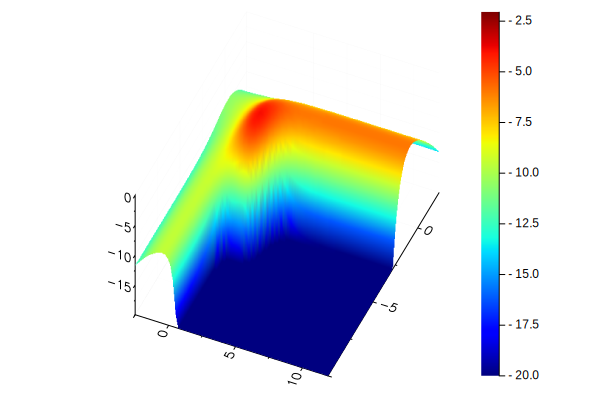

In [12]:
surface(theta2, theta3, z, seriescolor = cgrad(ColorSchemes.jet1.colors), camera = (30, 70))

In [17]:
res = optimize(x -> -logp!(hp1, [0, x...]), [-5.0, -5.0], [5.0, 5.0], [0.0, 0.0])
params = Optim.minimizer(res)
print(params)
logp!(hp1, [0, params...])

[1.72862, -2.48319]

-2.029922240006094

[1.59643, 6.5603, 0.0819847]

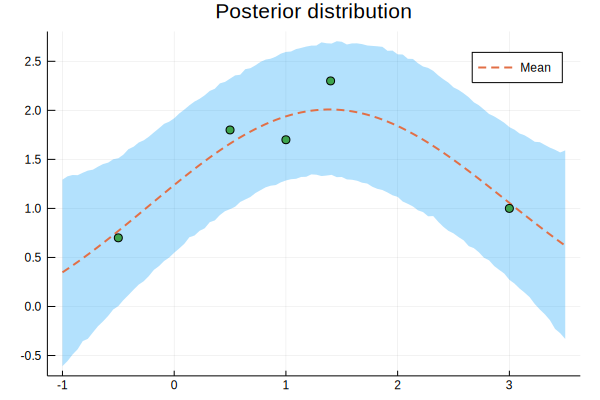

In [14]:
lower = [-5.0, -5.0, -5.0]
upper = [5.0, 5.0, 5.0]
res = optimize(x -> -logp!(hp1, x), lower, upper, [0.0, 0.0, 0.0])
params = Optim.minimizer(res)
print(exp.(params))

update!(gp, exp.(params)...)
xtrain = collect(range(-1, stop=3.5, length=100))
pred = gpr(hp1.gp, xtrain, xs, ys)
qt = mapslices(x -> quantile(x, [0.025, 0.975]), rand(pred, 10000), dims = 2)

Plots.plot(xtrain, qt[:, 1], fillrange = qt[:, 2], fillalpha = 0.3,
    label = "", linewidth = 0)
Plots.plot!(xtrain, mean(pred), label = "Mean", linewidth = 2, linestyle = :dash)

scatter!(xs, ys, label = "", title = "Posterior distribution")

In [15]:
# log likelihood
logp!(hp1, params)

-1.7387703743398149

## Add more points

[1.5245, 0.689286, 0.0670132]

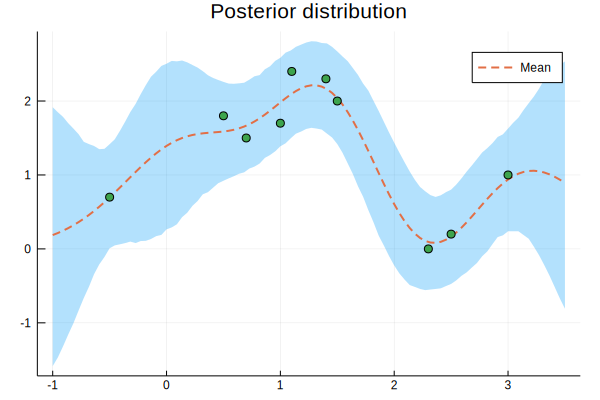

In [19]:
xs = [-0.5, 0.5, 1, 1.4, 3, 2.3, 2.5, 1.5, 1.1, 0.7]
ys = [0.7, 1.8, 1.7, 2.3, 1, 0, 0.2, 2, 2.4, 1.5]

hp2 = HyperParamHelper1(GaussianProcess(GaussianKernel(1, 1), 1), xs, ys)

res = optimize(x -> -logp!(hp2, x), lower, upper, [0.0, 0.0, 0.0])
params = Optim.minimizer(res)
print(exp.(params))

update!(gp, exp.(params)...)
xtrain = collect(range(-1, stop=3.5, length=100))
pred = gpr(hp2.gp, xtrain, xs, ys)
qt = mapslices(x -> quantile(x, [0.025, 0.975]), rand(pred, 10000), dims = 2)

Plots.plot(xtrain, qt[:, 1], fillrange = qt[:, 2], fillalpha = 0.3,
    label = "", linewidth = 0)
Plots.plot!(xtrain, mean(pred), label = "Mean", linewidth = 2, linestyle = :dash)

scatter!(xs, ys, label = "", title = "Posterior distribution")

In [20]:
# log likelihood
logp!(hp2, params)

-2.509299167686205